## Kill-Chain stages classification algorithm
#### Implementation and performance testing

_Note: This paper contains the implementation, as well as the results obtained by our team for the secondary purpose of KC implementation. However, the data used as set of anomalies has been previously identfied by my colleagues. I highly recommend visiting their work [here](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/tree/main/Matt/2%20-%20Anomaly%20Detection), as well as downloading the obtained set of anomalies, found [here](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/blob/main/Data/FinalAnomalies.txt)_.


In this paper we aim to finalise our work by making use of the previously identified set of anomalies towards the purpose of red_team classification in one of the 5 KC stages we isolated. The stages we will refer to are, chronologically: Reconnaissance, Delivery, Lateral Movement, Privilege Escalation and Exfiltration. To better understand how and why we came up with precisely these stages, you can find all research done [here](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/blob/main/Alex/4%20-%20Kill%20Chain/1%20-%20Kill%20chain%20research.ipynb). Our choice is the result of considering both 7-stages, as well as 8-stages models of the KC and fitting them to our data. We only consider those stages that we believe we can positively identify within our data.

We split our work into the following sections:


    1. Introduction and clustering methods

    2. Classification algorithm and initial results
    
    3. Second training phase: Retrospective chronology
    
    4. Final results and conclusions
        
      -  4.1 Results
        
      -  4.2 Conclusions
    
We require the following packages for our work:

In [231]:
# install.packages(c("factoextra", "ggpubr", "dplyr", "qqman", "svMisc", "qlcMatrix"))
library(qlcMatrix)
library(ggpubr)
library(factoextra)
library(dplyr)
library(qqman)
library(svMisc)

### 1. Introduction and clustering methods

For the purpose of group classification, the first tool that comes to mind is clustering. However, there are multiple layers to properly applying a grouping method to a specific end, in our case classification of every event in one of 5 possible outcomes. While we won't use a clustering approach for obtaining our classification results, it is the only reliable tool our team has identified towards verifying our results, at least to some degree of certitude. The first problem we identified was that most clustering approaches compare strictly numerical values, often exploiting mathematical relations between the values. Secondly, on boundary instances where events move from one stage to the other we expect smooth transitions. It is unlikely that a username's activity will switch from appearing as StageN to StageN+1 in an instant, so overlap of clusters is not only expected, but desired to the extent it highlights these transitions. Therefore, HDBSCAN strategies are ruled out before the start. Moreover, because we're interested in a specific number of K=5 clusters, the incentive is towards using K-means rather than DBSCAN. However, we will allow for multiple shapes rather than plain ellipsoids.

We will begin by testing our clustering technique on an older set of anomalies, that we considered before obtaining our final red_team data. This set remains within our [data folder](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/tree/main/Data) for record purposes only, as it features nowhere else in our work. It can still be found [here](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/blob/main/Data/FormerAnomalies.txt). I load it locally, to avoid memory concerns. However, it can be accessed directly from the source provided:

In [4]:
# setwd("D://LA//ATI Data")
df <- read.table(file="Anomalies.txt", header=T, sep=",")
df<- df[,-1]

head(df, 10)
dim(df)
str(df)

UserName,SrcDevice,DstDevice,Authent.Type,Failure,DailyCount
User341813,Comp948451,Comp915658,NetworkLogon,0,1
User341813,Comp948451,Comp915658,NetworkLogon,0,1
User341813,Comp948451,Comp915658,NetworkLogon,0,1
User341813,Comp948451,Comp915658,NetworkLogon,0,1
User341813,Comp948451,Comp915658,NetworkLogon,0,1
User341813,Comp948451,Comp915658,NetworkLogon,0,1
User341813,Comp948451,Comp915658,NetworkLogon,0,1
User341813,Comp948451,Comp915658,NetworkLogon,0,1
User341813,Comp948451,Comp004340,TGS,0,1
User341813,Comp948451,Comp004340,TGS,0,1


[1] 20412     6

'data.frame':	20412 obs. of  6 variables:
 $ UserName    : Factor w/ 81 levels "Administrator",..: 30 30 30 30 30 30 30 30 30 30 ...
 $ SrcDevice   : Factor w/ 489 levels "ActiveDirectory",..: 460 460 460 460 460 460 460 460 460 460 ...
 $ DstDevice   : Factor w/ 288 levels "ActiveDirectory",..: 258 258 258 258 258 258 258 258 2 2 ...
 $ Authent.Type: Factor w/ 12 levels "Batch","CachedInteractive",..: 4 4 4 4 4 4 4 4 9 9 ...
 $ Failure     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ DailyCount  : num  1 1 1 1 1 1 1 1 1 1 ...


We change the factors to strings so we can better manipulate the data.

In [7]:
df %>% mutate(across(where(is.factor), as.character)) -> df

str(df)

'data.frame':	20412 obs. of  6 variables:
 $ UserName    : chr  "User341813" "User341813" "User341813" "User341813" ...
 $ SrcDevice   : chr  "Comp948451" "Comp948451" "Comp948451" "Comp948451" ...
 $ DstDevice   : chr  "Comp915658" "Comp915658" "Comp915658" "Comp915658" ...
 $ Authent.Type: chr  "NetworkLogon" "NetworkLogon" "NetworkLogon" "NetworkLogon" ...
 $ Failure     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ DailyCount  : num  1 1 1 1 1 1 1 1 1 1 ...


As mentioned above, we will require our feature to be numerical in order to deploy clustering techniques. We translate all our connections to exact values:

In [8]:
t1<- tapply(df[,1], df[,1])
t2<- tapply(df[,2], df[,2])
t3<- tapply(df[,3], df[,3])
t4<- tapply(df[,4], df[,4])

Anom <- cbind(t1,t2,t3,t4, t5=df$Failure, t6=df$DailyCount)

head(Anom)

t1,t2,t3,t4,t5,t6
30,460,258,4,0,1
30,460,258,4,0,1
30,460,258,4,0,1
30,460,258,4,0,1
30,460,258,4,0,1
30,460,258,4,0,1


Finally, we initialize our first attempt at clustering. We will use a randomly selected start point, on 5 centers (one for each stage). The algorithm of choice will resort to the default, 'Lloyd':

In [9]:
set.seed(123)
K <- kmeans(Anom, centers=5, nstart = 25, algorithm="Lloyd", iter.max = 10^4)

We visualize it using fviz():

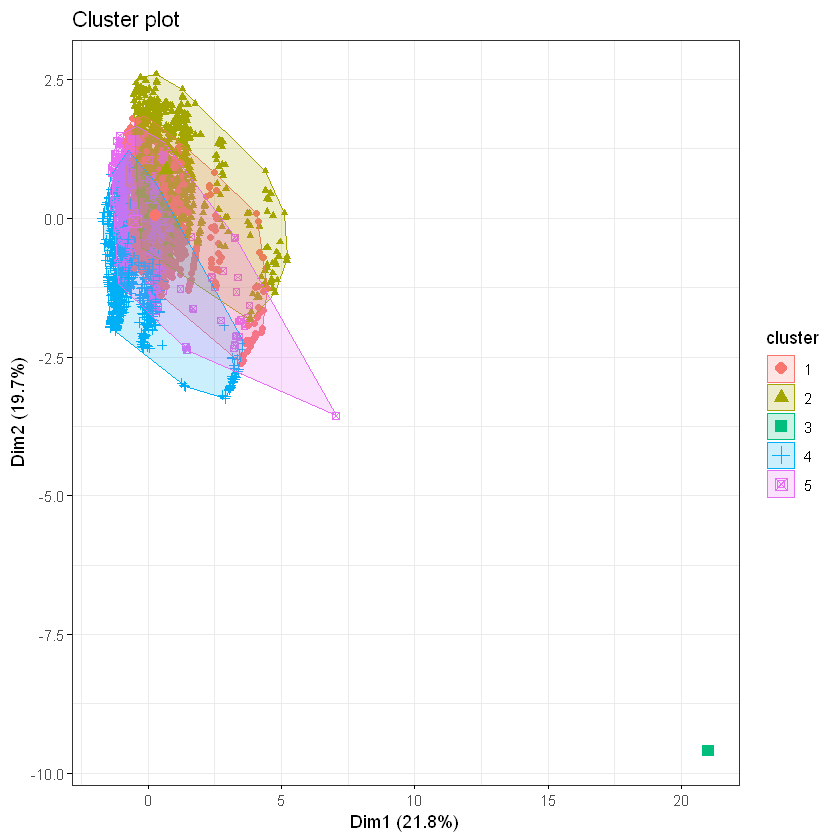

In [10]:
fviz_cluster(K, data = Anom, geom = "point",
             ellipse.type = "convex", 
             ggtheme = theme_bw()
             )

The following clusters were obtained:

In [12]:
table(K$cluster)


   1    2    3    4    5 
5076 6160    8 4938 4230 

These initial results are not representative of our final expectations, but certain trends can already be observed without any prior training. Particularly, the cluster with only 8 elements isolates 'outliers' from the other events that can be easily spotted by any competing model. We'll place the stages to classify the events within our data:

In [13]:
data <- cbind(df, Cluster = K$cluster)

head(data)

UserName,SrcDevice,DstDevice,Authent.Type,Failure,DailyCount,Cluster
User341813,Comp948451,Comp915658,NetworkLogon,0,1,2
User341813,Comp948451,Comp915658,NetworkLogon,0,1,2
User341813,Comp948451,Comp915658,NetworkLogon,0,1,2
User341813,Comp948451,Comp915658,NetworkLogon,0,1,2
User341813,Comp948451,Comp915658,NetworkLogon,0,1,2
User341813,Comp948451,Comp915658,NetworkLogon,0,1,2


The smallest cluster is as follows:

In [14]:
data[data$Cluster==3, ]

,UserName,SrcDevice,DstDevice,Authent.Type,Failure,DailyCount,Cluster
13024,AppService,EnterpriseAppServer,None,InteractiveLogon,1,17102,3
13117,AppService,EnterpriseAppServer,None,InteractiveLogon,1,17112,3
13218,AppService,EnterpriseAppServer,None,InteractiveLogon,1,17078,3
13219,AppService,EnterpriseAppServer,None,InteractiveLogon,1,17078,3
13340,AppService,EnterpriseAppServer,None,InteractiveLogon,1,17091,3
13395,AppService,EnterpriseAppServer,None,InteractiveLogon,1,17092,3
13438,AppService,EnterpriseAppServer,None,InteractiveLogon,1,17080,3
13663,AppService,EnterpriseAppServer,None,InteractiveLogon,1,17104,3


It's very likely that the coerced choice of having 5 clusters is suboptimal for the K-means grouping. To test that, we'll deploy the 'silhouette method testing' to identify the ideal number of clusters for our data. Other methods, such as the 'gap statistic' or the 'elbow' method would not yield different results, and they're moreover much more computationally heavy to run. Therefore, we will only present the former:

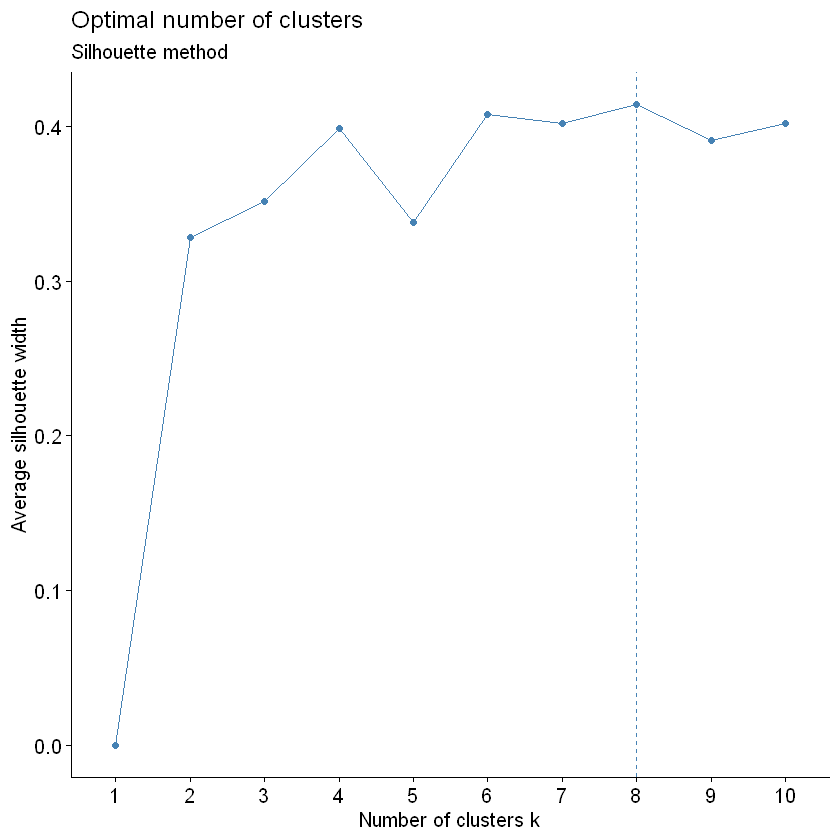

In [15]:
fviz_nbclust(Anom, FUNcluster=kmeans, method='silhouette') + labs(subtitle = "Silhouette method")
                    ## Gap static and elbow methods were also attempted, with poor results or no results at all.
                    ## Undocummented due to extensive computational length.

The result is that the optimal number of clusters for our data is eight. However, as seen from the graph, 5 clusters is one of the better choices as well. 

Lastly, we test whether changing our running algorithm influences the outcome anyhow. We will test two other candidates, the 'Hartigan-Wong' and the 'MacQueen' initialization respectively, and compare the resulting clusters:

In [16]:
set.seed(123)
K2 <- kmeans(Anom, centers=5, nstart = 25, algorithm="Hartigan-Wong", iter.max = 10^4)
K3 <- kmeans(Anom, centers=5, nstart = 25, algorithm="MacQueen", iter.max = 10^4)

table(K2$cluster)
table(K3$cluster)
                ## Similar results to 'Lloyd'


   1    2    3    4    5 
5003 4165 5051    8 6185 


   1    2    3    4    5 
4165    8 5002 5072 6165 

The results are very similar to 'Lloyd', hinting that choice of initialization algorithm doesn't matter to our data. The final parameter to consider is the starting point. We will test 50 different startpoints and compare through them using a distance metric for the normalized outputs:

In [17]:
set.seed(55)
options(warn=-1)
Km <- vector(len=50)
for(i in 1:50) {
    Km[i] <- kmeans(Anom, centers=5, nstart=i, algorithm="Lloyd", iter.max=10^4)
}

In [18]:
options(warn=1)

In [19]:
table(Km[50])
table(Km[1])
table(Km[25])


   1    2    3    4    5 
4176 5051    8 6174 5003 


   1    2    3    4    5 
2835 4814 3727 4243 4793 


   1    2    3    4    5 
6174    8 5051 4176 5003 

In [20]:
t1<- vector(len=50)
t2<- vector(len=50)
t3<- vector(len=50)
t4<- vector(len=50)
t5<- vector(len=50)
for(i in 1:50) {
    t1[i] <- as.vector(table(Km[i]))[1]
    t2[i] <- as.vector(table(Km[i]))[2]
    t3[i] <- as.vector(table(Km[i]))[3]
    t4[i] <- as.vector(table(Km[i]))[4]
    t5[i] <- as.vector(table(Km[i]))[5]
}

t1<- t1[order(t1, decreasing=FALSE)]
t2<- t2[order(t2, decreasing=FALSE)]
t3<- t3[order(t3, decreasing=FALSE)]
t4<- t4[order(t4, decreasing=FALSE)]
t5<- t5[order(t5, decreasing=FALSE)]

s1<- scale(t1)
s2<- scale(t2)
s3<- scale(t3)
s4<- scale(t4)
s5<- scale(t5)

In [21]:
manhattan_dist <- function(a, b){
     dist <- abs(a-b)
     dist <- sum(dist)
     return(dist)
}

In [22]:
M1 <- manhattan_dist(s1, s2)
M1
M2 <- manhattan_dist(s1, s3)
M2
M3 <- manhattan_dist(s1, s4)
M3
M4 <- manhattan_dist(s1, s5)
M4
cat("\n")
M5 <- manhattan_dist(s2, s3)
M5
M6 <- manhattan_dist(s2, s4)
M6
M7 <- manhattan_dist(s2, s5)
M7
cat("\n")
M8 <- manhattan_dist(s3, s4)
M8
M9 <- manhattan_dist(s3, s5)
M9
cat("\n")
M10 <- manhattan_dist(s4, s5)
M10

[1] 22.18659

[1] 22.07769

[1] 25.13818

[1] 17.99797

[1] 5.808436

[1] 6.608473

[1] 13.95672

[1] 9.62185

[1] 11.73321

[1] 17.01018

The following graphs output the relative distances between clusters. The higher the distance, the farther off clusters are off each other in terms of how many elements they contain. Therefore, lower distances are preferred.

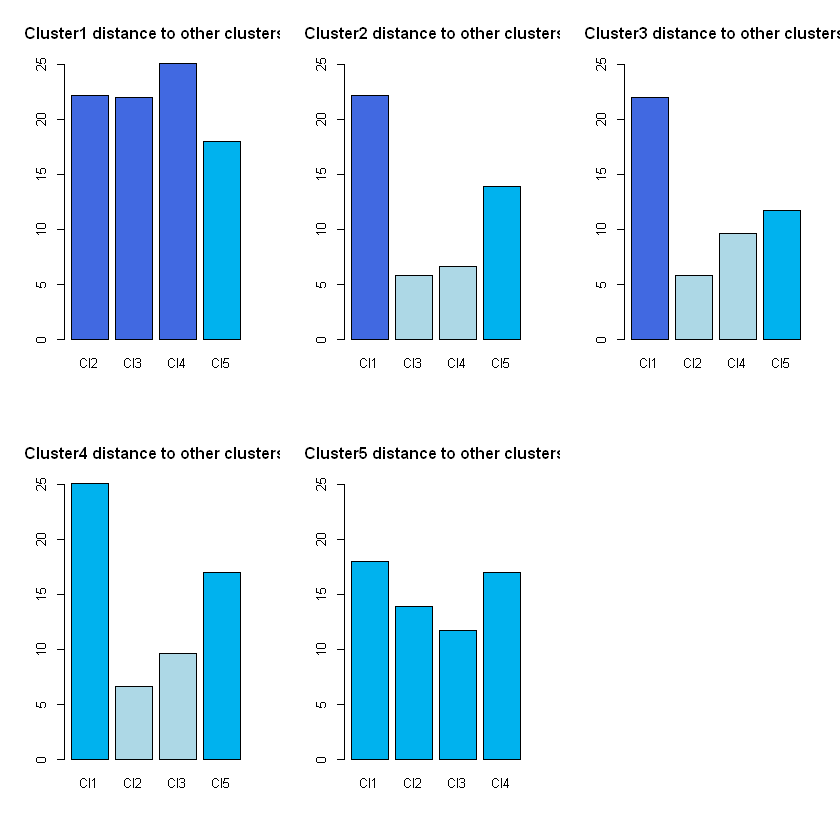

In [23]:
op <- par(mfrow=c(2,3))
x<- c(M1, M2, M3, M4)
barplot(c(M1,M2,M3,M4), main="Cluster1 distance to other clusters", names=c("Cl2", "Cl3", "Cl4", "Cl5"),
       ylim=c(0,25), col=ifelse(x>=20, "RoyalBlue", ifelse(10<x & x<20, 'DeepSkyBlue2', 'LightBlue')))
x<- c(M1, M5, M6, M7)
barplot(c(M1,M5,M6,M7), main="Cluster2 distance to other clusters", names=c("Cl1", "Cl3", "Cl4", "Cl5"),
       ylim=c(0,25), col=ifelse(x>=20, "RoyalBlue", ifelse(10<x & x<20, 'DeepSkyBlue2', 'LightBlue')))
x<- c(M2, M5, M8, M9)
barplot(c(M2,M5,M8,M9), main="Cluster3 distance to other clusters", names=c("Cl1", "Cl2", "Cl4", "Cl5"),
       ylim=c(0,25), col=ifelse(x>=20, "RoyalBlue", ifelse(10<x & x<20, 'DeepSkyBlue2', 'LightBlue')))
x<- c(M4, M6, M8, M10)
barplot(c(M3,M6,M8,M10), main="Cluster4 distance to other clusters", names=c("Cl1", "Cl2", "Cl3", "Cl5"),
       ylim=c(0,25), col=ifelse(x>=20, "RoyalBlue", ifelse(10<x & x<20, 'DeepSkyBlue2', 'LightBlue')))
x<- c(M4, M7, M9, M10)
barplot(c(M4,M7,M9,M10), main="Cluster5 distance to other clusters", names=c("Cl1", "Cl2", "Cl3", "Cl4"),
       ylim=c(0,25), col=ifelse(x>=20, "RoyalBlue", ifelse(10<x & x<20, 'DeepSkyBlue2', 'LightBlue')))
par(op)

The results seem to vastly vary based on the choice of initial starting point. The 2nd, 3rd and 4th clusters are often more similar than the rest. However, there are massive differences across the 1st and 5th cluster, presenting the largest Manhattan distance among all results. This is not yet informative enough to derive a general conclusion about clustering for our final purposes, but does raise questions about how to handle all the clustering parameters accordingly. Notably, in most cases the results follow an inverse-normal distribution, where the middle clusters contain the lowest numbers of members, with exceptionally high results within the edge clusters.

### 2. Classification algorithm and initial results

For the purpose of performing our actual stage classification, we chose the approach of implementing a Decision Tree (scoring tree) by hand, with decisions elected from past observations done in the [EDA section](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/tree/main/Alex/2%20-%20Exploratory%20Data%20Analysis), but mostly based off both hypothetical and actual instances of the stages manifestation, which we narrowed down in our [Kill Chain analysis section](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/blob/main/Alex/3%20-%20Anomaly%20Detection/1%20-%20Comparing%20Usernames.ipynb). Combining these with the [5 stages we identified](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/blob/main/Alex/4%20-%20Kill%20Chain/1%20-%20Kill%20chain%20research.ipynb), we chose to implement a very large series of decisions that attribute positive-only scores ranging from 0 to 2 to all stages, based on how confident we are that a certain connection belongs to that respective stage.

Crucially, instances of connections cannot be judged individually. Merely analysing an event is vastly insufficient to make the assertion that it belongs to one stage or the other. Therefore, most of the decisions presented put connections into the broader context of the whole network, looking at aspects such as username frequency, context of authentication types, destination preference, overall failure rate and many others. Full disclosure of every single decision implemented is infeasible to be translated in a single file, so we will document an example to serve as a paradigm to our method. The reasoning is as follows:

_How to perform the selection and score assignment?_

- We aim to run through the data only once, connection by connection. For every connection, we must identify the same set of questions to ask on basis of which we make our decisions regarding how many points of credence to assign to each of the 5 stages. Answers to a question may either be more indicative of Stage1, or of Stage2 and so on - in which case we assign more points to Stage1, respectively more points to Stage2 and so on. Admittedly, answers to questions are often indicative of multiple stages, or rather they may suggest the improbability of certain stages. It is perhaps not the case that it belongs to Stage1 or Stage2, but rather it doesn't seem to belong to any of the remaining 3 options. In such cases, we would like to assign credence to Stage1 and Stage2, but not so much as we would otherwise assign was the event directly indicative of those stages, instead of the indirect process-of-elimination scenario.

_What questions should we ask?_ 

- The questions, as mentioned above, have been vastly derived from conclusions drawn from the [Usernames comparison section](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/blob/main/Alex/3%20-%20Anomaly%20Detection/1%20-%20Comparing%20Usernames.ipynb). In that section we identify properties, sequences, features and patterns which indicate behaviour belonging to one or more stages, based on both actual data provided as well as hypothetical situations derived from the literature. However, we won't ask questions specifically targeted at certain stages, as that would constitute both an unfeasible as well as a potentially biased approach. Hence, rather than pointing at boolean indicators of whether something happens or not it enhances/doesn't enhance the chance of it belonging to StageN; we identify questions based on the features provided. We exclude 'UserName', since that feature alone will be used as a principal indicator of which set of connections we're targeting - and we focus all our attention to the 4 remaining features: SrcDevice, DstDevice, AuthType and Failure. The 'DailyCount' feature has been excluded as it increases computational complexity more than it aids decision making. For the 4 features considered, we isolated a number of 4 to 7 questions for each which would both constitute relevant statements on their own, as well as they would add information towards the task of stage distribution. The following exemplify questions we asked:

    1. _SrcDevice_: How many different users access this SrcDevice?; How many DstDevices are targeted from this SrcDevice?; Is this particular SrcDevice also a DstDevice in other connections, from the same UserName?

    2. _DstDevice_: How many DstDevices are accessed by this User? How many identical SameUser - SameSrcDevice - SameDstDevice connections exist?
    
    3. _AuthType_: What AuthType is this connection? How many different AuthTypes can be identified from this Username, on this SrcDevice?
    
    4. _Failure_: Does this connection fail? How often do connections identical to this one (except the Failure feature) fail?


To those questions we reply with our expectations regarding what would be indicative of each stage.

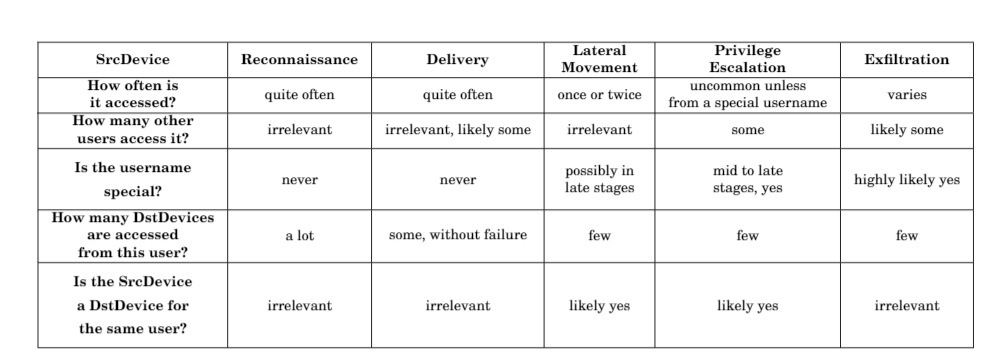

_What do we do once we get the answers to these questions we posed?_

- Once we have established the questions, all that remains to be done is to assign points accordingly. The scoring system, on surface, is highly intuitive. Places where the answer was 'irrelevant' towards a certain stage will imply that said stage receives no score at all regardless of the outcome of that question. For instance, whether a SrcDevice becomes DstDevice for the same Username in an ulterior connection isn't relevant towards Reconnaissance, so the YES/NO outcome will add/substract nothing towards Reconnaissance. Similarly, places where the answer clearly hints towards one option will distribute the points based on whether that option is satisfied, or proportionally to the degree to which it is satisfied, where applicable. As an example, the more destination devices a single username accesses from a source, the more it hints towards Reconnaissance, so based on where this number places relative to our current connection we allocate a set of points to Reconnaissance.


- On a deeper level, this strategy requires an immense amount of time and consideration dedicated towards balancing and allocation. While it is clear that a high number of points should be given when X occurs and fewer when it doesn't or does to a lesser degree, how many? We narrowed our interval to always assigning one of nine options, with no exception: +0/+0.25/+0.5/+0.75/+1/+1.25/+1.5/+1.75/+2. The reason for never assigning negative values is explained below. These values were chosen mainly for ease of computation, as well as being equally distanced and allowing for a large enough sample to distinguish among degrees of distribution. The scores were therefore carefully chosen in relation to each other, as well as to how indicative the given question is for assigning the event to the stage. If the criteria is perfectly fit to the question, but the question is not itself sufficiently suggestive towards the stage, the maximum amount attributed won't exceed 1.25/1.5, as opposed to the case where the question is also highly suggestive in which case the considered stage would be given +2. This reasoning was uniformly applied to all questions, as well as all their answers to the question. 

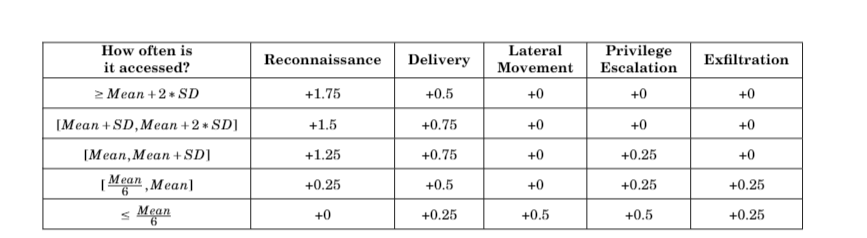

_What do we do with the points once assigned?_

- The point assignment system leaves us, at the end of the decision tree algorithm, with a set of 5 vectors, one for each stage, containing the credences that event 'i' belongs to their respective stage, indexed at 'i' as well. The reason we wanted our scores to be not only non-zero, but also negative, was so that they can then be transformed into probabilities, each row adding up to 1. The non-negative condition was implicitly satisfied by our assignment, where the lowest score assigned was always +0. The non-zero condition was to be dodged by either the implementation of a smoothing factor of 0.05 that would be added to every single score, or by starting every score from 0.05 rather than 0. Both methods had their advantages and disadvantages, however, neither implementation was necessary in the end, since the minimum value any score achieved was greater than one even. 


- Transforming each score into probabilities will allow us to identify not only which stage is most likely to represent a given red_team connection, but also evaluate what the odds of it belonging to the other connections is. Counterintuitively, our aim is not to achieve a large gap between values. If that occurs, by the algorithm's construction, it's likely that the events with the highest scores will not only dominate that specific connection, but also a spectrum of similar connections, either from the same username, or to the same destination or similar in other such aspects. This would result in clusters containing very few elements, with one massive group being attributed to likely Reconnaissance or Exfiltration. Although that is still likely to happen, we aim to alleviate this process by keeping scores within a close range of each other. This way, once there is sufficient evidence for an event to transition from one stage to the other, it will do so, even if by a small adding margin of +0.25 or +0.5. This way we ensure fluency throughout the whole Kill Chain, rather than getting stuck on individual stages. 


Hence, let us write the algorithm:

In [232]:
DecisionScoring <- function(df=df) {

Reconnaissance <- as.vector(rep(0, times=nrow(df)))
Delivery <- Reconnaissance
LateralMovement <- Delivery
PrivilegeEscalation <- LateralMovement
Exfiltration <- PrivilegeEscalation
    
Z <- 1

for(i in 1:nrow(df)) {
    
    
    User <- df[i,]$UserName
    Src <- df[i,]$SrcDevice
    Dst <- df[i,]$DstDevice
    AT <- df[i,]$Authent.Type
    FA <- df[i,]$Failure
    
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    
    SourceFrequency <- df[df$SrcDevice==Src, ]
    UserFrequency <- df[df$UserName==User, ]
    UserAndSourceFrequency <- UserFrequency[UserFrequency$SrcDevice==Src, ]
    DestinationFrequency <- df[df$DstDevice==Dst, ]
    
    NSF <- nrow(SourceFrequency)
    t<- table(df$SrcDevice)
    M<- mean(t)
    S<- sd(t)
    if(NSF>= M + 2*S) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.75
        Delivery[i] <- Delivery[i] + 0.5
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
     if(NSF/nrow(df)>=M+S & NSF/nrow(df)<M+2*S) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.5
        Delivery[i] <- Delivery[i] + 0.75
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
     if(NSF/nrow(df)>=M & NSF/nrow(df)<M+S) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.25
        Delivery[i] <- Delivery[i] + 0.75
        # LateralMovement[i] <- LateralMovement[i] + 0
        if(User%in%Special==TRUE) {
            PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
            }
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
     if(NSF/nrow(df)>=M/6 & NSF/nrow(df)<M) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.25
        Delivery[i] <- Delivery[i] + 0.5
        # LateralMovement[i] <- LateralMovement[i] + 0
        if(User%in%Special==TRUE) {
            PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
            }
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
     if(NSF/nrow(df)<M/6) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.75
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.75
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
     L <- length(unique(SourceFrequency$UserName))
     if(L>=12) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1
        Exfiltration[i] <- Exfiltration[i] + 0.5
         }
     if(L>=9 & L<12) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.75
        Exfiltration[i] <- Exfiltration[i] + 0.25 
     }
     if(L>=5 & L<9) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.5
        Exfiltration[i] <- Exfiltration[i] + 0.25
     }
     if(L>=2 & L<5) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
     }
    if(L==1) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        # Delivery[i] <- Delivery[i] + 0
        LateralMovement[i] <- LateralMovement[i] + 0.5
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(User%in%Special==TRUE) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        # Delivery[i] <- Delivery[i] + 0
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1
        Exfiltration[i] <- Exfiltration[i] + 1.5 
    }
    if(User%in%Special==FALSE) {
        Reconnaissance[i] <- Reconnaissance[i] + 1
        Delivery[i] <- Delivery[i] + 1
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        # Exfiltration[i] <- Exfiltration[i] + 0
    }

    L <- length(unique(UserAndSourceFrequency$DstDevice))
    l <- length(unique(df$DstDevice))
    if(L/l>=0.4) {
        Reconnaissance[i] <- Reconnaissance[i] + 2
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0 
    }
    if(L/l>=0.2 & L/l<0.4) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.75
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(L/l>=0.1 & L/l<0.2) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.5
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(L/l>=0.05 & L/l<0.1) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.25
        Delivery[i] <- Delivery[i] + 0.25
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(L>=11 & L<34) {
        Reconnaissance[i] <- Reconnaissance[i] + 1
        Delivery[i] <- Delivery[i] + 0.5
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(L>=6 & L<11) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.5
        Delivery[i] <- Delivery[i] + 0.75
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    if(L>=3 & L<6) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.25
        Delivery[i] <- Delivery[i] + 0.75
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.75
        Exfiltration[i] <- Exfiltration[i] + 0.5
    }
    if(L<=2) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.75
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1
        Exfiltration[i] <- Exfiltration[i] + 0.75
    }
    Destinations <- unique(UserFrequency$DstDevice)
    if(Src%in%Destinations==TRUE){
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        # Delivery[i] <- Delivery[i] + 0
        LateralMovement[i] <- LateralMovement[i] + 3
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1.25
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    
    D<- table(df$DstDevice)
    M<- mean(D)
    S<- sd(D)
    N<- nrow(df[df$DstDevice==Dst, ])
    if(N>=M+2*S){
        Reconnaissance[i] <- Reconnaissance[i] + 1.25
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        if(User%in%Special==TRUE) {
            Exfiltration[i] <- Exfiltration[i] + 1.5  
        }
        if(User%in%Special==FALSE) {
            Exfiltration[i] <- Exfiltration[i] + 0.5  
        }
    }
    if(N>=M+S & N<M+2*S) {
        Reconnaissance[i] <- Reconnaissance[i] + 1
        # Delivery[i] <- Delivery[i] + 0
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        if(User%in%Special==TRUE) {
            Exfiltration[i] <- Exfiltration[i] + 1.5  
        }
        if(User%in%Special==FALSE) {
            Exfiltration[i] <- Exfiltration[i] + 0.25  
        }
    }
    if(N>=M & N<M+S) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.75
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        if(User%in%Special==TRUE) {
            Exfiltration[i] <- Exfiltration[i] + 0.75  
        }
        if(User%in%Special==FALSE) {
            Exfiltration[i] <- Exfiltration[i] + 0.25  
        }
    }
    if(N>=M/4 & N<M) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.5
        Delivery[i] <- Delivery[i] + 0.75
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(N>=4 & N<M/4) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.25
        Delivery[i] <- Delivery[i] + 1
        LateralMovement[i] <- LateralMovement[i] + 0.5
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(N<4) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.75
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    
    U<- length(unique(DestinationFrequency$UserName))
    L<- length(unique(df$UserName))
    if(U>=L/5) {
        Reconnaissance[i] <- Reconnaissance[i] + 1
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        if(User%in%Special==TRUE) {
            Exfiltration[i] <- Exfiltration[i] + 0.5
        }
    }
    if(U>=L/10 & U<L/5) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.75
        Delivery[i] <- Delivery[i] + 0.25
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        if(User%in%Special==TRUE) {
            Exfiltration[i] <- Exfiltration[i] + 0.5
        }
    }
    if(U>=L/20 & U<L/10) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.5
        Delivery[i] <- Delivery[i] + 0.25
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        if(User%in%Special==TRUE) {
            Exfiltration[i] <- Exfiltration[i] + 0.75
        }
    }
    if(U<L/20) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.25
        # Delivery[i] <- Delivery[i] + 0
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        if(User%in%Special==TRUE) {
            Exfiltration[i] <- Exfiltration[i] + 1.25
        }
    }
    
    S<- length(unique(DestinationFrequency$SrcDevice))
    L<- length(unique(df$SrcDevice))
    if(S/L>=0.2) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.75
        # Delivery[i] <- Delivery[i] + 0
        LateralMovement[i] <- LateralMovement[i] + 0.75
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        Exfiltration[i] <- Exfiltration[i] + 0.5 
    }
    if(S/L>=0.1 & S/L<0.2) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.25
        # Delivery[i] <- Delivery[i] + 0
        LateralMovement[i] <- LateralMovement[i] + 0.5
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    if(S/L>=0.05 & S/L<0.1) {
        Reconnaissance[i] <- Reconnaissance[i] + 1
        # Delivery[i] <- Delivery[i] + 0
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    if(S>=24 & S<47) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.75
        # Delivery[i] <- Delivery[i] + 0
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        Exfiltration[i] <- Exfiltration[i] + 0.25
     }
    if(S>=5 & S<24) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.5
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    if(S>=2 & S<5) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.5
        # LateralMovement[i] <- LateralMovement[i] + 0
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        Exfiltration[i] <- Exfiltration[i] + 0.5
    }
    if(S==1) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 1.25
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    
    Identical <- UserAndSourceFrequency[UserAndSourceFrequency$DstDevice==Dst, ]
    I <- nrow(Identical)
    if(I>12) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.25
        Delivery[i] <- Delivery[i] + 0.25
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(I>9 & I<=12) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.75
        Delivery[i] <- Delivery[i] + 0.25
        # LateralMovement[i] <- LateralMovement[i] + 0
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(I>6 & I<=9) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.5
        Delivery[i] <- Delivery[i] + 0.5
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    if(I>3 & I<=6) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.5
        Delivery[i] <- Delivery[i] + 0.5
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    if(I>1 & I<=3) {
        if(sum(Identical$Failure)==nrow(Identical)) {
            Reconnaissance[i] <- Reconnaissance[i] + 0.25
            }
        Delivery[i] <- Delivery[i] + 0.5
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        Exfiltration[i] <- Exfiltration[i] + 0.5
    }
    if(I==1) {
        if(Identical$Failure==1) {
            Reconnaissance[i] <- Reconnaissance[i] + 0.25
        }
        Delivery[i] <- Delivery[i] + 1.25
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        Exfiltration[i] <- Exfiltration[i] + 0.75
    }
    
    A<- length(unique(UserAndSourceFrequency$Authent.Type))
    if(A>3) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.25
        Delivery[i] <- Delivery[i] + 1.5
        # LateralMovement[i] <- LateralMovement[i] + 0
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        # Exfiltration[i] <- Exfiltration[i] + 0  
    }
    if(A==3) {
        Reconnaissance[i] <- Reconnaissance[i] + 1
        Delivery[i] <- Delivery[i] + 1.25
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.5
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    if(A==2) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.75
        Delivery[i] <- Delivery[i] + 1
        LateralMovement[i] <- LateralMovement[i] + 0.75
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.5
        Exfiltration[i] <- Exfiltration[i] + 1
    }
    if(A==1) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.25
        Delivery[i] <- Delivery[i] + 0.75
        LateralMovement[i] <- LateralMovement[i] + 1.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.5
        Exfiltration[i] <- Exfiltration[i] + 1.25
    }
    
    Identical <- Identical[Identical$Authent.Type==AT, ]
    I <- nrow(Identical)
    if(I>=2) {
        Reconnaissance[i] <- Reconnaissance[i] + 2
        Delivery[i] <- Delivery[i] + 1
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        Exfiltration[i] <- Exfiltration[i] + 0.25  
    }
    if(I==1) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.5
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.75
        Exfiltration[i] <- Exfiltration[i] + 1
    }
    
    Identical <- UserAndSourceFrequency[UserAndSourceFrequency$DstDevice==Dst, ]
    AuthTypes <- length(unique(Identical$Authent.Types))
    if(AuthTypes>=2) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.75
        Delivery[i] <- Delivery[i] + 1.5
        LateralMovement[i] <- LateralMovement[i] + 1.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.5
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(AuthTypes==1) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.5
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    
    if(FA==1) {
        Reconnaissance[i] <- Reconnaissance[i] + 2
        Delivery[i] <- Delivery[i] + 1.5
        LateralMovement[i] <- LateralMovement[i] + 1.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        # Exfiltration[i] <- Exfiltration[i] + 0 
    }
    if(FA==0) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.5
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1.5
        Exfiltration[i] <- Exfiltration[i] + 2
    }
    
    OF <- sum(UserAndSourceFrequency$Failure)
    SF <- nrow(UserAndSourceFrequency)
    if(OF/SF>=0.8) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.75
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(OF/SF>=0.5 & OF/SF<0.8) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.5
        Delivery[i] <- Delivery[i] + 0.5
        LateralMovement[i] <- LateralMovement[i] + 0.25
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(OF/SF>=0.2 & OF/SF<0.5) {
        Reconnaissance[i] <- Reconnaissance[i] + 1.25
        Delivery[i] <- Delivery[i] + 1
        LateralMovement[i] <- LateralMovement[i] + 0.5
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(OF/SF>=0.1 & OF/SF<0.2) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.5
        Delivery[i] <- Delivery[i] + 1.25
        LateralMovement[i] <- LateralMovement[i] + 0.75
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(OF/SF>=0.02 & OF/SF<0.1) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.25
        Delivery[i] <- Delivery[i] + 1
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.5
        Exfiltration[i] <- Exfiltration[i] + 0.25
    }
    if(OF/SF<0.02) {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.5
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1.5
        Exfiltration[i] <- Exfiltration[i] + 2
    }
    
    Identical <- Identical[Identical$Authent.Type==AT, ]
    FI <- length(unique(Identical$Failure))
    if(FI>=2) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.5
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.5
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(FI==1) {
        Reconnaissance[i] <- Reconnaissance[i] + 0.25
        Delivery[i] <- Delivery[i] + 0.75
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1.75
        Exfiltration[i] <- Exfiltration[i] + 2
    }
    
    if(AT=='TGT') {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.75
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1.5
        Exfiltration[i] <- Exfiltration[i] + 1.75
    }
    if(AT=='TGS') {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 1
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1.5
        Exfiltration[i] <- Exfiltration[i] + 1.75
    }
    if(AT=='InteractiveLogon' | AT=='RemoteInteractive') {
        Reconnaissance[i] <- Reconnaissance[i] + 1.5
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 1
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        # Exfiltration[i] <- Exfiltration[i] + 0 
    }
    if(AT=='NetworkLogon') {
        Reconnaissance[i] <- Reconnaissance[i] + 1.75
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        # Exfiltration[i] <- Exfiltration[i] + 0 
    }
    if(AT=='Batch') {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 1.5
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.5
        Exfiltration[i] <- Exfiltration[i] + 1.25 
    }
    if(AT=='Service') {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 1.5
        LateralMovement[i] <- LateralMovement[i] + 0.5
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1.75
        Exfiltration[i] <- Exfiltration[i] + 1.25 
    }
    if(AT=='WorkstationLock') {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.75
        # LateralMovement[i] <- LateralMovement[i] + 0
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        Exfiltration[i] <- Exfiltration[i] + 2 
    }
    if(AT=='WorkstationUnlock') {
        Reconnaissance[i] <- Reconnaissance[i] + 0.75
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 1
        Exfiltration[i] <- Exfiltration[i] + 0.25 
    }
    if(AT=='ScreensaverInvoked') {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.75
        # LateralMovement[i] <- LateralMovement[i] + 0
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(AT=='ScreensaverDismissed') {
        # Reconnaissance[i] <- Reconnaissance[i] + 0
        Delivery[i] <- Delivery[i] + 0.25
        LateralMovement[i] <- LateralMovement[i] + 0.5
        # PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    if(AT=='CachedInteractive') {
        Reconnaissance[i] <- Reconnaissance[i] + 0.75
        Delivery[i] <- Delivery[i] + 0.5
        LateralMovement[i] <- LateralMovement[i] + 0.25
        PrivilegeEscalation[i] <- PrivilegeEscalation[i] + 0.25
        # Exfiltration[i] <- Exfiltration[i] + 0
    }
    
    # if(i/nrow(df)*100>=Z) {
     #    print(paste("Progress:", Z, "%."))
      #   Z <- Z+1
       #  cat("\n")
    # Sys.sleep(0.01)
      #   }
    
    progress(i)
    Sys.sleep(0.01)
}
  Stages <<- as.data.frame(cbind(Reconnaissance, Delivery, LateralMovement, PrivilegeEscalation, Exfiltration))
    }

With this decision tree structure, we obtain a raw set of scores assigned for each of the 5 stages. As previously mentioned, we want to test against a single stage dominating the others in order to be able to later on establish a chronological order among stages. To do so, we start by considering an equal ground for each of the 5 stages of 1/5 = 0.2 = 20% equal probability assigned for each. If either of the stages has an assignment beloe 15%, it's likely that, by our DT's construction and points assignment, 1 or 2 more stages will be above 25% rather than a similar spread between the remaining 4 stages of ~22%/23%. In this scenario, the difference between the maximum and minimum stage exceeds 25-15 = 10%. 

Therefore, in the worst case scenario, chronology of stages may dictate moving from the >25% stage to the <15% stage within the upcoming connections, such as moving from 'lateral movement' to 'privilege escalation' or from 'delivery' to 'lateral movement'. In this case, the distance between the two may grow too large to address without forcing bias. To avoid this, we may thus require stages to never be separated by more than 10% respective to their total sum. We will try updating our decisions to match this criteria, and aim towards having as many connections as possible respect the formula of: 

**Max - Min <= Sum/10 = 10% * Sum**. 

We will test this condition across our results with the following function:

In [233]:
StagesIntegrityTest <- function() {
    c<- 0
    for(i in 1:nrow(Stages)) {
        S <- sum(Stages[i, ])
        MaxMin <- max(Stages[i, ]) - min(Stages[i, ])
        if(MaxMin <= S/10) {
            c <- c+1
        }
    }
    print(paste("The integrity of Stages is", c/nrow(Stages)*100, "%."))
}

With the Decision Tree and the StageIntegrity() test finalised, we are ready to use them on our final set of anomalies. The set of anomalies can be found and loaded from [here](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/blob/main/Data/FinalAnomalies.txt), though, once again, we are loading them locally in the code-block below:

###### Final anomalies

In [234]:
setwd("D://LA//ATI Data")
df <- read.table(file="FinalAnomalies.txt", header=T, sep=",")
df<- df[,-1]

df %>% mutate(across(where(is.factor), as.character)) -> df

str(df)
head(df,10)
dim(df)

'data.frame':	38712 obs. of  8 variables:
 $ UserName    : chr  "User735240" "User735240" "User735240" "User735240" ...
 $ SrcDevice   : chr  "Comp700191" "Comp700191" "Comp738078" "Comp700191" ...
 $ DstDevice   : chr  "Comp774964" "Comp700191" "ActiveDirectory" "ActiveDirectory" ...
 $ Authent.Type: chr  "NetworkLogon" "NetworkLogon" "TGT" "TGT" ...
 $ Failure     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ DailyCount  : num  3 1 1 1 2 1 1 1 1 18 ...
 $ Hour        : int  0 0 5 6 12 17 18 19 19 23 ...
 $ Day         : int  59 59 59 59 59 59 59 59 59 59 ...


UserName,SrcDevice,DstDevice,Authent.Type,Failure,DailyCount,Hour,Day
User735240,Comp700191,Comp774964,NetworkLogon,0,3,0,59
User735240,Comp700191,Comp700191,NetworkLogon,0,1,0,59
User735240,Comp738078,ActiveDirectory,TGT,0,1,5,59
User735240,Comp700191,ActiveDirectory,TGT,0,1,6,59
User735240,Comp738078,Comp700191,TGS,0,2,12,59
User735240,Comp738078,Comp700191,RemoteInteractive,0,1,17,59
User735240,Comp700191,Comp370444,TGS,0,1,18,59
User735240,Comp700191,Comp700191,TGS,0,1,19,59
User735240,Comp700191,Comp370444,NetworkLogon,0,1,19,59
User735240,Comp700191,ActiveDirectory,NetworkLogon,0,18,23,59


[1] 38712     8

Unlike the previous set of anomalies, this one was partitioned by the daily and hourly activity of each username, while also being ordered user-by-user rather than chronologically. For our purposes, we will need to first order it chronologically, and then remove the last 3 features.
To do so, we will make use of the temporal indices we're being given. We'll add the hours to the days so that 12 hours into day N corresponds to day N.5, and then use the results to order the data:

In [235]:
df$Day <- df$Day + df$Hour/24
head(df)

UserName,SrcDevice,DstDevice,Authent.Type,Failure,DailyCount,Hour,Day
User735240,Comp700191,Comp774964,NetworkLogon,0,3,0,59.00000
User735240,Comp700191,Comp700191,NetworkLogon,0,1,0,59.00000
User735240,Comp738078,ActiveDirectory,TGT,0,1,5,59.20833
User735240,Comp700191,ActiveDirectory,TGT,0,1,6,59.25000
User735240,Comp738078,Comp700191,TGS,0,2,12,59.50000
User735240,Comp738078,Comp700191,RemoteInteractive,0,1,17,59.70833


In [236]:
df<- df[order(df$Day), ]
head(df, 20)

,UserName,SrcDevice,DstDevice,Authent.Type,Failure,DailyCount,Hour,Day
1079,User288751,Comp468329,Comp253429,TGS,0,1,0,58
1080,User288751,Comp468329,Comp370444,NetworkLogon,0,19,0,58
1081,User288751,Comp916004,Comp916004,TGS,0,16,0,58
1082,User288751,Comp468329,Comp797582,NetworkLogon,0,2,0,58
1649,User396223,Comp068848,ActiveDirectory,TGT,0,2,0,58
2765,User341813,Comp948451,Comp915658,NetworkLogon,0,4,0,58
2766,User341813,Comp107130,Comp916004,NetworkLogon,0,27,0,58
3358,User091297,Comp955934,Comp939275,NetworkLogon,0,2,0,58
3440,User379647,Comp416133,Comp370444,TGS,0,1,0,58
3441,User379647,Comp416133,ActiveDirectory,TGS,0,10,0,58


Now that the data is well ordered, we can remove the last 3 columns:

In [237]:
df<- df[,-c(6:8)]
head(df)

,UserName,SrcDevice,DstDevice,Authent.Type,Failure
1079,User288751,Comp468329,Comp253429,TGS,0
1080,User288751,Comp468329,Comp370444,NetworkLogon,0
1081,User288751,Comp916004,Comp916004,TGS,0
1082,User288751,Comp468329,Comp797582,NetworkLogon,0
1649,User396223,Comp068848,ActiveDirectory,TGT,0
2765,User341813,Comp948451,Comp915658,NetworkLogon,0


_At this stage we have our desired dataset_

Lastly, we define the set of 'Special' usernames that get called from within the global environment into our decision tree, before running the algorithm:

In [238]:
g<- grep(pattern='User', x=df$UserName)
Special <- unique(df$UserName[-g])
g<- grep(pattern='Comp', x=Special)
Special <- Special[-g]
Special

[1] "winservice"    "AppService"    "Administrator"

In [239]:
DecisionScoring(df)

Progress:   1%Progress:   2%Progress:   3%Progress:   4%Progress:   5%Progress:   6%Progress:   7%Progress:   8%Progress:   9%Progress:  10%Progress:  11%Progress:  12%Progress:  13%Progress:  14%Progress:  15%Progress:  16%Progress:  17%Progress:  18%Progress:  19%Progress:  20%Progress:  21%Progress:  22%Progress:  23%Progress:  24%Progress:  25%Progress:  26%Progress:  27%Progress:  28%Progress:  29%Progress:  30%Progress:  31%Progress:  32%Progress:  33%Progress:  34%Progress:  35%Progress:  36%Progress:  37%Progress:  38%Progress:  39%Progress:  40%Progress:  41%Progress:  42%Progress:  43%Progress:  44%Progress:  45%Progress:  46%Progress:  47%Progress:  48%Progress:  49%Progress:  50%Progress:  51%Progress:  52%Progress:  53%Progress:  54%Progress:  55%Progress:  56%Progress:  57%Progress:  58%Progress:  59%Progress:  60%Progress:  61%Progress:  62%Progress:  63%Progress:  64%Progress:  65%Progress:  66%Progress:  67%Progress:  68%Progress:  69%Progress:  70%Progress:  71%Progre

The raw results are as follows:

In [240]:
head(Stages, 25)

Reconnaissance,Delivery,LateralMovement,PrivilegeEscalation,Exfiltration
8.00,7.75,7.75,9.25,9.25
12.50,6.50,7.50,7.75,7.50
10.25,7.25,7.75,11.25,10.50
8.75,7.75,7.00,8.25,7.00
10.25,7.25,7.75,9.25,9.50
14.00,7.50,7.50,6.75,5.50
11.25,6.00,5.50,8.75,9.75
11.25,7.50,5.00,6.00,5.50
6.75,7.00,8.75,10.25,11.00
6.75,7.00,8.75,10.25,11.00


To these, we apply the stage integrity test, which we hope to get as high as possible:

In [241]:
StagesIntegrityTest()

[1] "The integrity of Stages is 34.5655094027692 %."


The results are comforting enough to provide good backing for what will be implemented in section 3.
Now, with the current points assignment, we may wish transform them into probabilities, as well as assign our expected stages based on the highest probability to each event. The following function does so:

In [242]:
StageAssignExpect <- function() {
    R <- rowSums(Stages)
    Probs <- Stages/R
    Maximum <- pmax(Probs$Reconnaissance,Probs$Delivery,Probs$LateralMovement,Probs$PrivilegeEscalation,Probs$Exfiltration)
    Probs_with_clusters <- cbind(Probs, Maximum)
    
    Cluster <- vector(len=nrow(Probs_with_clusters))
for(i in 1:nrow(Probs_with_clusters)) {
    if(Probs_with_clusters$Maximum[i]==Probs_with_clusters$Reconnaissance[i]) {
        Cluster[i] <- "R"
    }
    if(Probs_with_clusters$Maximum[i]==Probs_with_clusters$Delivery[i]) {
        Cluster[i] <- "D"
    }
    if(Probs_with_clusters$Maximum[i]==Probs_with_clusters$LateralMovement[i]) {
        Cluster[i] <- "LM"
    }
    if(Probs_with_clusters$Maximum[i]==Probs_with_clusters$PrivilegeEscalation[i]) {
        Cluster[i] <- "PE"
    }
    if(Probs_with_clusters$Maximum[i]==Probs_with_clusters$Exfiltration[i]) {
        Cluster[i] <- "E"
    }
}

Probs_with_clusters <<- cbind(UserName = df$UserName, Probs_with_clusters, Cluster)

}

We now call it and output the results:

In [243]:
StageAssignExpect()

In [244]:
head(Probs_with_clusters, 15)

UserName,Reconnaissance,Delivery,LateralMovement,PrivilegeEscalation,Exfiltration,Maximum,Cluster
User288751,0.1904762,0.1845238,0.1845238,0.2202381,0.2202381,0.2202381,E
User288751,0.2994012,0.1556886,0.1796407,0.1856287,0.1796407,0.2994012,R
User288751,0.2180851,0.1542553,0.1648936,0.2393617,0.2234043,0.2393617,PE
User288751,0.2258065,0.2000000,0.1806452,0.2129032,0.1806452,0.2258065,R
User396223,0.2329545,0.1647727,0.1761364,0.2102273,0.2159091,0.2329545,R
User341813,0.3393939,0.1818182,0.1818182,0.1636364,0.1333333,0.3393939,R
User341813,0.2727273,0.1454545,0.1333333,0.2121212,0.2363636,0.2727273,R
User091297,0.3191489,0.2127660,0.1418440,0.1702128,0.1560284,0.3191489,R
User379647,0.1542857,0.1600000,0.2000000,0.2342857,0.2514286,0.2514286,E
User379647,0.1542857,0.1600000,0.2000000,0.2342857,0.2514286,0.2514286,E


Lastly, let us see what the grouping distribution looks like:

In [245]:
T1 <- table(Probs_with_clusters$Cluster)
T1


    D     E    LM    PE     R 
 1285  8539   190  2370 26328 

The results are mostly on par with our initial expectations. They follow an inverse-normal distribution, where 'Reconnaissance' and 'Exfiltration' contain by far the largest number of elements, with downfall in the middle and 'Lateral Movement' containing the smallest amount. We are overall satisfied with the number of elements that have been identified in each group. Initial results spotted as few as 8 to 10 elements in LM, which have been corrected by a series of carefully implemented adjustments in the scoring system to better understand what makes an event potentially LM, D or PE.


We will save these results for later use in a variable:

In [246]:
OldProbs <- Probs_with_clusters

Lastly, we'll look at how clustering performs on this initial set of stages:


    1     2     3     4     5 
 5645  5715  9124  3408 14820 

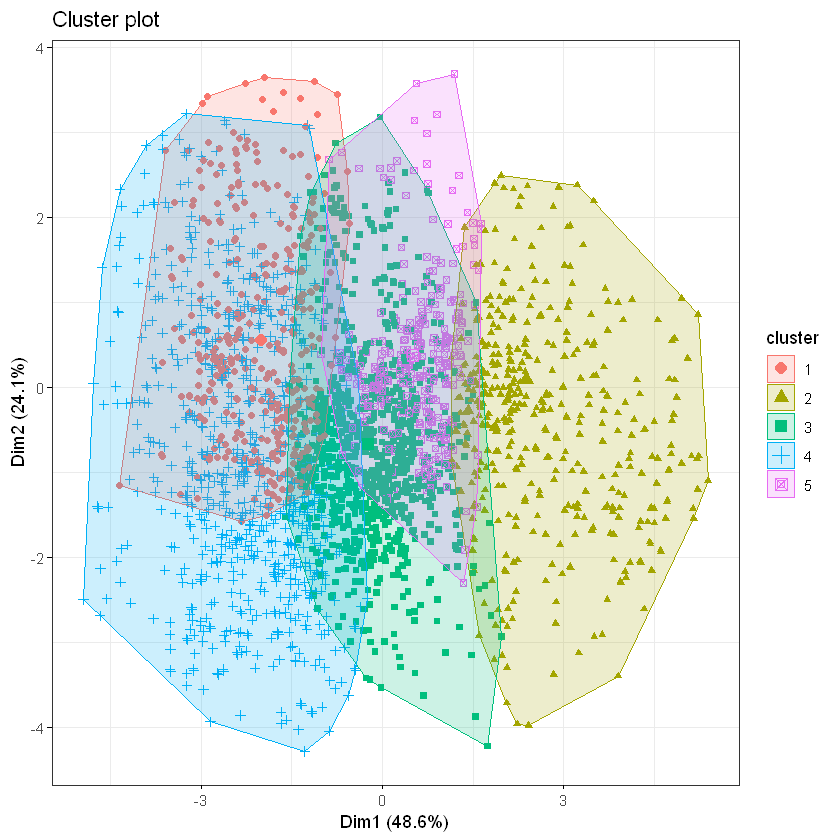

In [247]:
K1 <- kmeans(Stages, centers=5, nstart = sample(1:nrow(Stages), size=1), algorithm="Lloyd", iter.max = 10^4)
TK1 <- table(K1$cluster)
TK1

fviz_cluster(K1, data = Stages, geom = "point",
             ellipse.type = "convex", 
             ggtheme = theme_bw()
             )

The overall result is desirable. Clusters present similar tendencies to our initial results, though the events are more evenly spread out across corresponding groups. Notably, some clusters are almost fully contained within others, as there is an observable level of overlap across them. The parts where edge portions of clusters intersect with other, similarly sized clusters, was expected and even desired as a result - since separating stages immediately following one another should be a smooth process, rather than a hard established threshold. However, there is no way to tell from this picture alone whether intersecting clusters correspond to consecutive stages, or if they correspond to stages at all. One concern is that, while the numbers of events captured are similar to our decision tree results, the events captured may very well in fact belong to different stages of the kill chain, being captured by our collections based on different criteria than the ones we based our assignment on. We will address these two crucial concerns in our 4th and final section for conclusions and results.


Until then, we are yet to establish chronology across the events. Although the obtained values are, to some degree, satisfactory, we are yet to call it a proper classification. As it stands, there are more instances where consecutive connections are identified as belonging to completely opposite stages, eg. Reconnaissance, Exfiltration, PE and then again Reconnaissance; than there are of normal ordering. This issue needs immediate addressing before drawing final results, which we will do in the next section.

### 3. Retrospective chronology: 2nd training phase

For the purpose of establishing chronological ordering for our KC stages, we decided on implementing a retrospective approach or a secondary training phase, posterior to obtaining the initial set of values for each classification. To do so, we decided on a Markov chain approach, where each event's updated score is a result of the previous event's stage classification. This ensures coherence and proper continuity within our data, by adding extra weight to the idea that if a previous connection was assigned StageN, the immediate following connection can only be seen as StageN itself or StageN+1.


In order for a connection to move on from one stage to the next, there needs to be some evidence discovered within the 1st training phase, i.e. the decision tree algorithm, that hints towards transition. Assigning more credence to the hypothesis that the (n+1)th connection will maintain the nth connection's status rather than moving to the next stage, or likewise to the alternative hypothesis that it will change status represent transgressions of our method and create implicit bias in the assignment system. Hence, whichever value we choose to use for moderation of our scores to exhibit chronology would have to be the same across both possible Markov jumps: remaining the same stage or moving farther into the chain.

We will load the previously obtained scores into a dataset:

In [248]:
PWC <- as.data.frame(cbind(UserName = Probs_with_clusters$UserName, Stages, Cluster = Probs_with_clusters$Cluster))
head(PWC, 5)

UserName,Reconnaissance,Delivery,LateralMovement,PrivilegeEscalation,Exfiltration,Cluster
User288751,8.00,7.75,7.75,9.25,9.25,E
User288751,12.50,6.50,7.50,7.75,7.50,R
User288751,10.25,7.25,7.75,11.25,10.50,PE
User288751,8.75,7.75,7.00,8.25,7.00,R
User396223,10.25,7.25,7.75,9.25,9.50,R


For training chronology, we will design a function that does precisely as described above. The only remaining factor to establish is the value of score that gets added to consecutive stages. However, we have already considered that in section 2. The StageIntegrity() function measures how many rows of stage scores respect the rule of Max - Min <= Sum/10. Since we aim to maximize the outcome of that function, and we don't want to add unnecessarily large values to consecutive stages, it suffices to add any amount over _S/10 >= Max - Min_. For good measure, we will simply designate _F = 1.1*(S/10)_, which covers the gap of _Max-Min_ and very little above.

In [249]:
L <- as.list(unique(Probs_with_clusters$UserName))
length(L)

[1] 94

In [250]:
RedistributeWeight <- function() {
    df <- data.frame()
    for(User in L) {        
        data <- PWC[PWC$UserName==User, ]
        data$Reconnaissance[1] <- data$Reconnaissance[1] + 1.5
        data$Cluster[1] <- 'R'
        if(nrow(data)>=2) {
            M <- vector(len=nrow(data)-1)
            S <- vector(len=nrow(data)-1)
            for(i in 2:nrow(data)) {
                M[i-1] <- max(c(data$Reconnaissance[i-1], data$Delivery[i-1], data$LateralMovement[i-1], data$PrivilegeEscalation[i-1], data$Exfiltration[i-1]))
                S[i] <- sum(c(data[i,2], data[i,3], data[i,4], data[i,5], data[i,6]))
                F <- 1.1*(S[i]/10)
                if(M[i-1]==data$Reconnaissance[i-1]) {
                    data$Reconnaissance[i] <- data$Reconnaissance[i] + F
                    data$Delivery[i] <- data$Delivery[i] + F
                }
                if(M[i-1]==data$Delivery[i-1]) {
                    data$LateralMovement[i] <- data$LateralMovement[i] + F
                    data$Delivery[i] <- data$Delivery[i] + F
                }
                if(M[i-1]==data$LateralMovement[i-1]) {
                    data$LateralMovement[i] <- data$LateralMovement[i] + F
                    data$PrivilegeEscalation[i] <- data$PrivilegeEscalation[i] + F
                }
                if(M[i-1]==data$PrivilegeEscalation[i-1]) {
                    data$PrivilegeEscalation[i] <- data$PrivilegeEscalation[i] + F
                    data$Exfiltration[i] <- data$Exfiltration[i] + F
                }
                if(M[i-1]==data$Exfiltration[i-1]) {
                    data$Exfiltration[i] <- data$Exfiltration[i] + F
                }
            }
        }
        df <- as.data.frame(rbind(df, data))
    }
    UpdatedStages <<- df
}

Let's now output the results:

In [251]:
RedistributeWeight()

In [252]:
head(UpdatedStages)

,UserName,Reconnaissance,Delivery,LateralMovement,PrivilegeEscalation,Exfiltration,Cluster
1,User288751,9.5000,7.7500,7.75,9.25,9.25,R
2,User288751,17.0925,11.0925,7.50,7.75,7.50,R
3,User288751,15.4200,12.4200,7.75,11.25,10.50,PE
4,User288751,13.0125,12.0125,7.00,8.25,7.00,R
78,User288751,15.1225,10.8725,7.50,7.50,7.50,R
243,User288751,13.2575,14.0075,7.25,9.50,8.75,PE


Although the scores have been updated, we have to re-assign the clusters, as the current clusters don't represent the actual values. To do so, we will re-run the StageAssignment function. Furthermore, due to our redistribution method which followed a user-by-user sequencing, we need to re-order the data as it was previously:

In [253]:
US <- UpdatedStages[order(as.numeric(rownames(UpdatedStages)), decreasing=FALSE), ]

We get rid of everything except the values:

In [254]:
Stages <- US[, -c(1,7)]

The following are the updated scores:

In [255]:
head(Stages)

Reconnaissance,Delivery,LateralMovement,PrivilegeEscalation,Exfiltration
9.5000,7.7500,7.75,9.25,9.25
17.0925,11.0925,7.50,7.75,7.50
15.4200,12.4200,7.75,11.25,10.50
13.0125,12.0125,7.00,8.25,7.00
11.7500,7.2500,7.75,9.25,9.50
15.5000,7.5000,7.50,6.75,5.50


Lastly, we re-assign their clusters:

In [256]:
StageAssignExpect()

In [257]:
head(Probs_with_clusters, 10)

UserName,Reconnaissance,Delivery,LateralMovement,PrivilegeEscalation,Exfiltration,Maximum,Cluster
User288751,0.2183908,0.1781609,0.1781609,0.2126437,0.2126437,0.2183908,R
User288751,0.3355748,0.2177776,0.1472465,0.1521547,0.1472465,0.3355748,R
User288751,0.2689222,0.2166027,0.1351587,0.1961981,0.1831182,0.2689222,R
User288751,0.2752512,0.2540984,0.1480698,0.1745108,0.1480698,0.2752512,R
User396223,0.2582418,0.1593407,0.1703297,0.2032967,0.2087912,0.2582418,R
User341813,0.3625731,0.1754386,0.1754386,0.1578947,0.1286550,0.3625731,R
User341813,0.3137109,0.2093890,0.1092896,0.1738698,0.1937407,0.3137109,R
User091297,0.3469388,0.2040816,0.1360544,0.1632653,0.1496599,0.3469388,R
User379647,0.1823204,0.1546961,0.1933702,0.2265193,0.2430939,0.2430939,E
User379647,0.1389961,0.1441441,0.1801802,0.2110682,0.3256113,0.3256113,E


These are the updated results, based on our decision tree together with the retrospective chronology training: 

In [258]:
T2 <- table(Probs_with_clusters$Cluster)
T2


    D     E    LM    PE     R 
 3345  8734  1205  1327 24101 

Based on these new scores, this is what the new clusters look like when using K-means:


    1     2     3     4     5 
10705  4413 13232  3923  6439 

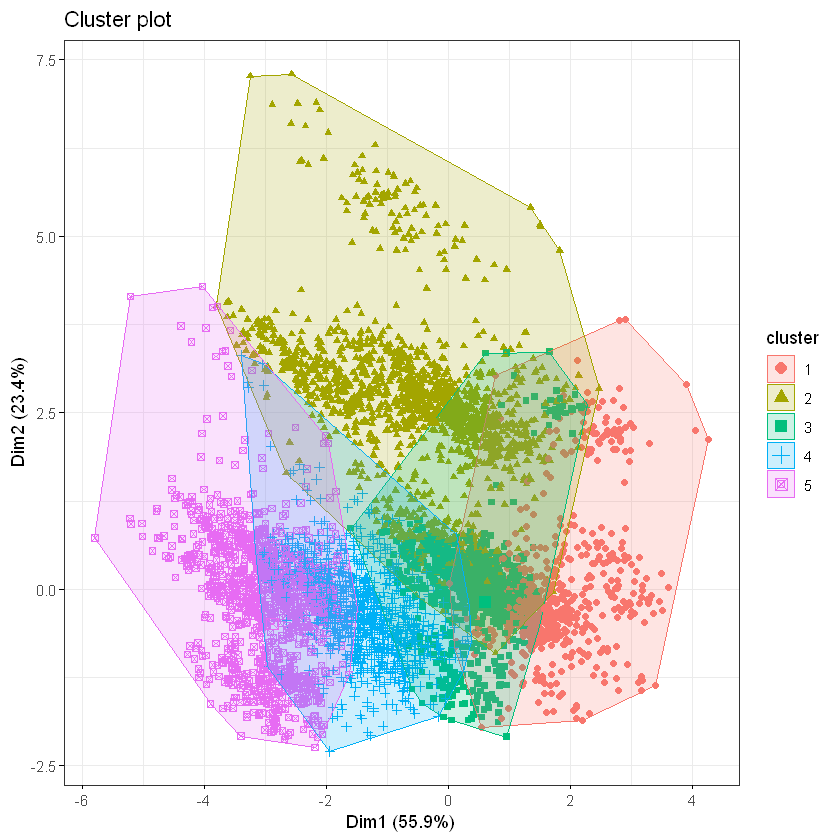

In [259]:
K2 <- kmeans(Stages, centers=5, nstart = sample(1:nrow(Stages), size=1), algorithm="Lloyd", iter.max = 10^4)
TK2 <- table(K2$cluster)
TK2

fviz_cluster(K2, data = Stages, geom = "point",
             ellipse.type = "convex", 
             ggtheme = theme_bw()
             )

From a brief comparison with the naked eye, one can tell that there have been no momentous changes across clusters in either of the algorithmic results nor the K-means results. However, both exhibit similar changes from their initial implementation, mostly aimed at uniforming the groupings more. Particularly, Reconnaissance went from covering over 26.3k datapoints in the initial results, down to about 24k in the updated results. The loss of ~2.3k results was evenly distributed across underpopulated stages like Delivery and Lateral Movement, which was essentially our intention with this 2nd training phase. Likewise, a similar trend can be observed in the K-means clusters, where one cluster was initially dominating with 14.8K members, and in the redistributed outcome it shrank to ~13.2k. Moreover, the loss, much alike the case with the stages assignment, was evenly distributed across clusters 3 and 5 mostly.

These results remain to be subject to a far more thorough analysis, which we aim to perform in the next and final section of our work. 

## 4. Final results and conclusions

This section will be split into two subsections: 'Results', and then 'Conclusions'

### 4.1 Results

In this subsection we will analyse the previously obtained results from the four main approaches. To better visualise the 4 grouping results and how we got to them, we consider the following simple diagram:

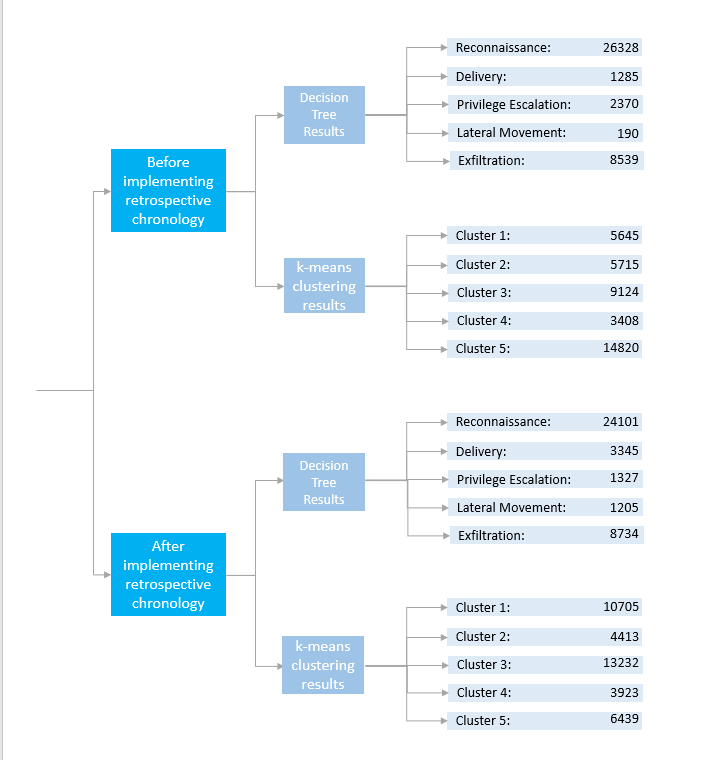

As seen above, these 4 independent results can be interpreted from multiple angles: We can either compare the difference across initial results v.s updated results, compare the initial algorithmic results to the initial clustering ones or compare the updated algorithmic results to the updated K-means ones. The latter approach where our expectations are compared with the resulting groupings from an unsupervised model is what we intend to use as a performance metric. Unfortunately, due to the distinct natures of our methods, notable differences between these two outcomes are indicative of failure, but do not provide us with any insight on what has to be changed in our approach. However, little to no differences are a good indication of success for our method.

However, it's crucial we consider proportional allocation rather than raw allocation, since, for instance, the Reconnaissance stage resulting from our decision algorithm has sufficient events to its name to completely cover the two largest clusters identified by K-means, which allocated a much more even spread between groups. Therefore, when we get to comparing results, a trivial domination from Reconnaissance and Exfiltration is to be expected. The importantly decisive factor will, however, be the percentage of allocation of the less represented stages, such as how much % of the Privilege Escalation stage features in cluster X. This type of analysis will help us match decisions to clusters despite the numerical noise produced by the large amount of R and E. The former stage's allocation is indeed a precaution choice of our decisions, since all anomalous events start as being suspected of reconnaissance. Most of them, individually, don't make it past that stage, hence contributing to the biggest cluster. 

Our main focus of analysis will be on the match between clusters assignment and their overlap against the stages assignment and their proper order. We will aim to see whether we have managed to match an individual stage with a single cluster and, in the expected cases where this does not hold since the distribution of elements differ as mentioned above, whether we have the right situations of overlaps. Before that, however, we will briefly look into how different group sizes are to begin with. To do so, we save all the values in 4 different vectors, one for the _'Initial Decision tree stage assignment'_, one for the 'Updated Decision tree stage assignment', one for the 'Initial K-means cluster assignment' and one for the 'Updated K-means cluster assignment':  

In [260]:
TF1 <- as.vector(T1) # Initial Alg
TF2 <- as.vector(T2) # Updated Alg

YK1 <- as.vector(TK1) # Initial Clust
YK2 <- as.vector(TK2) # Updated Clust

We define a normalization function that we'll use to scale down all values to the same level, so that the numerical gap won't affect our results:

In [261]:
normalize <- function(x) {
    y<- vector(len=length(x))
    S <- sum(x)
    for(i in 1:length(x)) {
        y[i] <- x[i]/S
    }
    invisible(y)
    }

We normalize all 4 vectors accordingly:

In [262]:
TFN1 <- normalize(TF1)
TFN2 <- normalize(TF2)
YKN1 <- normalize(YK1)
YKN2 <- normalize(YK2)

# TFN1 <- TFN1[order(TFN1, decreasing=FALSE)]
# TFN2 <- TFN2[order(TFN2, decreasing=FALSE)]
# YKN1 <- YKN1[order(YKN1, decreasing=FALSE)]
# YKN2 <- YKN2[order(YKN2, decreasing=FALSE)]

TFN1
TFN2
YKN1
YKN2

[1] 0.033193842 0.220577599 0.004908039 0.061221327 0.680099194

[1] 0.08640732 0.22561480 0.03112730 0.03427878 0.62257181

[1] 0.14582042 0.14762864 0.23568919 0.08803472 0.38282703

[1] 0.2765292 0.1139957 0.3418062 0.1013381 0.1663309

Lastly, we consider the differences before and after chronology updating between the results we got directly from the decision tree and the results gained from K-means clustering. We will visualise them below:

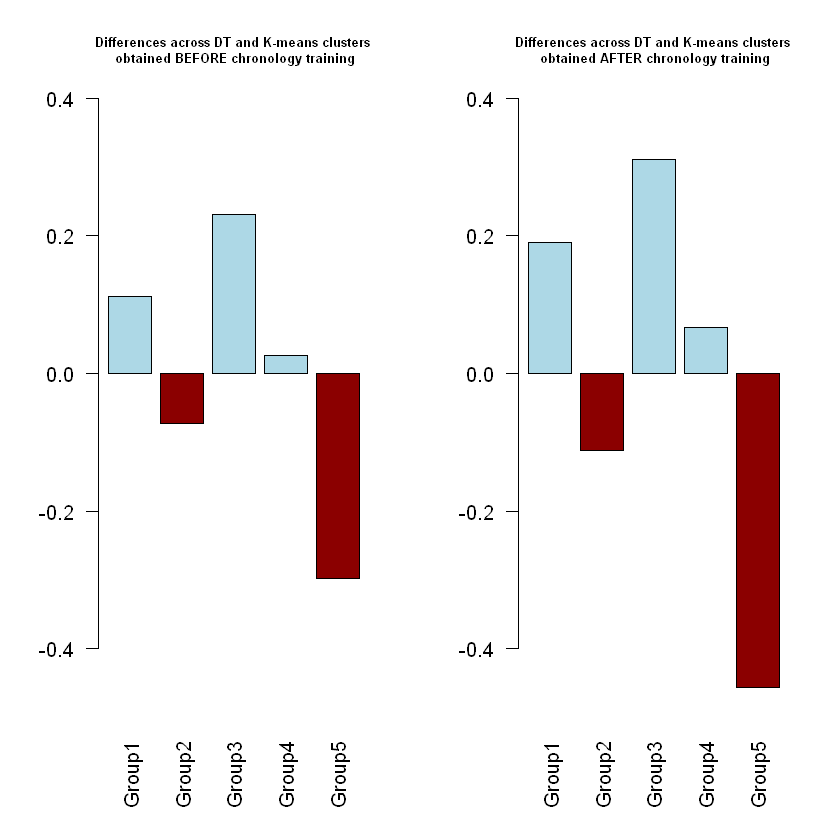

In [263]:
Initial <- YKN1 - TFN1
Updated <- YKN2 - TFN2
ISum <- sum(Initial)
USum <- sum(Updated)

op <- par(mfrow=c(1,2)) 
barplot(Initial, ylim=c(-0.5, 0.4), col=ifelse(Initial<0, 'DarkRed', 'LightBlue'), names=c(paste0("Group", c(1:5))), 
    main="Differences across DT and K-means clusters\n obtained BEFORE chronology training", cex.main=0.65, las=2)
barplot(Updated, ylim=c(-0.5, 0.4), col=ifelse(Updated<0, 'DarkRed', 'LightBlue'), names=c(paste0("Group", c(1:5))), 
    main="Differences across DT and K-means clusters\n obtained AFTER chronology training", cex.main=0.65, las=2)
par(op)

The two training phases seem to highlight a trend of shifting values down in favour of the stage assignment. All differences shrank, both in cases where clusters had more elements (i.e. the blue, positive bars) as well as cases where they had fewer (i.e. the red, negative bars). 

We will now analyze how stages fit against clusters and the other way around. To do so, we load the clusters and our expectations of stages side-by-side, both in the initial case as well as the updated chronology case:

In [264]:
InitialResults <- cbind(Expectation = as.character(OldProbs$Cluster), Result = K1$cluster)
InitialResults <- as.data.frame(InitialResults)

UpdatedResults <- cbind(Expectation = as.character(Probs_with_clusters$Cluster), Result = K2$cluster)
UpdatedResults <- as.data.frame(UpdatedResults)

Lastly, before outputting the results, we will create two functions.

The first one we will call 'ResultMatching()' aims to provide the best fit match for a cluster to a stage, given our results. This is done by measuring where the highest concentration of that specific cluster lies in terms of the 5 stages it gets distributed among. Likewise, the second function called 'StageMatching()' provides the same analysis from a stage's perspective, where we aim to understand the best fit of a specific stage to a cluster. This will measure where the highest number of elements belonging to that stage lie in terms of the 5 clusters provided by the K-means approach. 

Combining these two, we hope to convincingly allocate unique (Stage, Cluster) pairs. The common challenges we are prepared to face are given by the mismatch between sizes of clusters and sizes of stages groupings, as seen in the previous plot. Likely results are to notice a seeming domination of Reconnaissance and Exfiltration across all clusters, which we aim to fix using the 2nd function. Vice-versa, to account for size differences across clusters, we will make use of our first function. 

In [267]:
ResultMatching <- function(df=UpdatedResults)
    {
Cluster1 <- df[df$Result==1, ]
Cluster2 <- df[df$Result==2, ]
Cluster3 <- df[df$Result==3, ]
Cluster4 <- df[df$Result==4, ]
Cluster5 <- df[df$Result==5, ]


print(paste("There is a", (max(table(Cluster1[1])))/nrow(Cluster1)*100, "% match for cluster 1 with stage", names(which.max(table(Cluster1[1])))))
cat("\n")
print(paste("There is a", (max(table(Cluster2[1])))/nrow(Cluster2)*100, "% match for cluster 2 with stage", names(which.max(table(Cluster2[1])))))
cat("\n")
print(paste("There is a", (max(table(Cluster3[1])))/nrow(Cluster3)*100, "% match for cluster 3 with stage", names(which.max(table(Cluster3[1])))))
cat("\n")
print(paste("There is a", (max(table(Cluster4[1])))/nrow(Cluster4)*100, "% match for cluster 4 with stage", names(which.max(table(Cluster4[1])))))
cat("\n")
print(paste("There is a", (max(table(Cluster5[1])))/nrow(Cluster5)*100, "% match for cluster 5 with stage", names(which.max(table(Cluster5[1])))))
cat("\n")
    }

In [268]:
StageMatching <- function(df=UpdatedResults)
    {
    R <- df[df$Expectation=='R', ]
    D <- df[df$Expectation=='D', ]
    LM <- df[df$Expectation=='LM', ]
    PE <- df[df$Expectation=='PE', ]
    E <- df[df$Expectation=='E', ]
    
    print(paste(max(table(R[2]))/sum(table(R[2]))*100, "% of Reconnaissance features in cluster", names(which.max(table(R[2])))))
    cat("\n")
    print(paste(max(table(D[2]))/sum(table(D[2]))*100, "% of Delivery features in cluster", names(which.max(table(D[2])))))
    cat("\n")
    print(paste(max(table(LM[2]))/sum(table(LM[2]))*100, "% of Lateral Movement features in cluster", names(which.max(table(LM[2])))))
    cat("\n")
    print(paste(max(table(PE[2]))/sum(table(PE[2]))*100, "% of Privilege Escalation features in cluster", names(which.max(table(PE[2])))))
    cat("\n")
    print(paste(max(table(E[2]))/sum(table(E[2]))*100, "% of Exfiltration features in cluster", names(which.max(table(E[2])))))
    cat("\n")
  
}

### 4.2 Conclusions

In this final subsection we discuss the results achieved throughout this paper, as well as how successful they are to our goal. We will also aim to briefly answer some common questions one might naturally have upon reaching this step. Firstly, however, we begin by outputting the results. A much more thorough analysis will be performed on the end results achieved after chronology assignment, since those interest us the most. The initial results will be used as a model for our conclusions.

#### 4.2.1 Initial results

The following are the results for the 1st training phase, before chronology updating:

In [265]:
table(InitialResults)

           Result
Expectation     1     2     3     4     5
         D      0    20  1047   218     0
         E   5193     0   797  2549     0
         LM     0     2   164    23     1
         PE   309     0  1443   618     0
         R    143  5693  5673     0 14819

This table is more easily understood through our two pre-defined functions:

In [269]:
ResultMatching(df=InitialResults)
cat("\n\n")
StageMatching(df=InitialResults)

[1] "There is a 91.9929140832595 % match for cluster 1 with stage E"

[1] "There is a 99.6150481189851 % match for cluster 2 with stage R"

[1] "There is a 62.1766768960982 % match for cluster 3 with stage R"

[1] "There is a 74.7946009389671 % match for cluster 4 with stage E"

[1] "There is a 99.9932523616734 % match for cluster 5 with stage R"



[1] "56.2860832573686 % of Reconnaissance features in cluster 5"

[1] "81.4785992217899 % of Delivery features in cluster 3"

[1] "86.3157894736842 % of Lateral Movement features in cluster 3"

[1] "60.8860759493671 % of Privilege Escalation features in cluster 3"

[1] "60.8150837334583 % of Exfiltration features in cluster 1"



The expected cluster dominance of Reconnaissance and Exfiltration stages is indeed present, which does not allow for any of the other 3, less represented, stages to feature among the result matches. When it comes to stage matching, Over 56% of all Reconnaissance is present in a single cluster, namely cluster 5, whereas the rest of it can be seen in the table as evenly spread in clusters 2 and 3 - where it also has an impactful presence numbers-wise. We can quite confidently match Delivery to cluster 3, with over 81% presence there, but similarly lateral movement and privilege escalation. 

This phenomenon can be explained through the massive clusters overlap that can be seen in the first figure. Although this leaves us having to make more assumptions regarding which of the three fits in which of the 3 clusters numbered 2,3 and 4; it's a good result in itself that 3 consecutive stages are part of the overlap, rather than non-consecutive ones. Particularly, lateral movement overlaps most with delivery and privilege escalation, whereas the latter two don't overlap as much with each other. Lastly, exfiltration has the most impactful presence in cluster 1 - both as stage to cluster as well as cluster to stage matching. 

From this short analysis, we can draw the following conclusions:

_Stage_ ~ _Cluster_ : _Level of confidence in our matching ( Certainty, Highly likely, Quite likely, Better than guessing, Guessing )_

1. Reconnaissance - Cluster _5_: **Certainty**


2. Delivery - Cluster _2_: **Better than guessing**


3. Lateral Movement - Cluster _3_ : **Highly likely**


4. Privilege Escalation - Cluster _4_ : **Quite likely**


5. Exfiltration - Cluster _1_ : **Certainty**


These initial assignments are imperfect, since two stages have been matched to the same cluster. However, there are no grounds on which we could assign either of Lateral Movement nor Delivery to cluster 2. Not only do they not have a stage to cluster presence within them, but the other way around numerically hints to reconnaissance - which adds noise due to its large size. In terms of percentages, delivery presents 20 elements in cluster 2 out of a total of 1285 (with 1047 in cluster 3) - which amounts to 20/1285 ~ 1.55% overall presence, whereas lateral movement contains 2 of its 190 elements in cluster 2, which amounts to 2/190 ~ 1.05% overall presence. Neither of these values are sufficiently convincing for us to assign either stage to cluster 2. However, as we already know that lateral movement is highly likely to be assigned cluster 3, we can deduce that delivery ought to belong to cluster 2.

We will perform a similar analysis on the updated results, where we expect to get better results. On top of that, we will discuss the implications of our outcomes then, as the chronology trained model is the one that holds importance for our goals.

#### 4.2.2 Updated results

Finally, the following represent our end results, after the 2nd training phase for chronology updating:

In [266]:
table(UpdatedResults)

           Result
Expectation     1     2     3     4     5
         D    160  1674  1426    85     0
         E      0    10     4  2494  6226
         LM     0  1204     0     1     0
         PE     0   651     0   463   213
         R  10545   874 11802   880     0

Similarly, we will refer to our functions:

In [270]:
ResultMatching()
cat("\n\n")
StageMatching()

[1] "There is a 98.5053713218122 % match for cluster 1 with stage R"

[1] "There is a 37.9333786539769 % match for cluster 2 with stage D"

[1] "There is a 89.1928657799274 % match for cluster 3 with stage R"

[1] "There is a 63.5737955646189 % match for cluster 4 with stage E"

[1] "There is a 96.6920329243671 % match for cluster 5 with stage E"



[1] "48.9689224513506 % of Reconnaissance features in cluster 3"

[1] "50.0448430493274 % of Delivery features in cluster 2"

[1] "99.9170124481328 % of Lateral Movement features in cluster 2"

[1] "49.0580256217031 % of Privilege Escalation features in cluster 2"

[1] "71.2846347607053 % of Exfiltration features in cluster 5"



The overarching dominance of Reconnaissance and Exfiltration across all 5 clusters remains present within the updated results, although not as prominent as before. Particularly, there is an ~38% match of cluster 2 with D, which means that the Delivery stage, despite its small size, was the most present stage in that particular cluster. Excluding Delivery, the only other present stage in the 1st cluster is Reconnaissance, with ~47% of its total size and > 98.5% presence in cluster 1. When it comes to Lateral Movement, it is also trivial to match to it with cluster 2 since over 99.9% of its elements feature in that space. Delivery presents almost equal presence in both clusters 2 and 3, but since the former was assigned to LM, we conclude that it must belong to cluster 3 instead. 

Despite ~49% of PE featuring in cluster 2, we can easily see how that overlaps with LM as well as D, similarly so to the initial results. However, the next largest chunk of PE can be identified in cluster 4 where, percentage-wise, PE is by a margin the best candidate to occupy it with 463/1327 ~ 35% of its total presence, followed by Exfiltration with 2494/8734 ~ 28.5% of its total presence. Once again, overlap between PE and E is not only expected, but welcome as part of the transition between stages. Lastly, cluster 5 represents Exfiltration beyond reasonable doubt, with some little overlap across Privilege Escalation once again. Notably, all of the identified cross-over is pertinent, in the sense that consecutive stages are almost exclusively the ones that overlap, and certainly the ones that present the highest margin both raw and percentage-wise of overlap.

From this analysis, we draw the following conclusions:

_Stage ~ Cluster : Level of confidence in our matching ( Certainty, Highly likely, Quite likely, Better than guessing, Guessing )_


1. Reconnaissance - Cluster _1_: **Highly likely**


2. Delivery - Cluster _3_: **Highly likely**


3. Lateral Movement - Cluster _2_ : **Certainty**


4. Privilege Escalation - Cluster _4_ : **Certainty**


5. Exfiltration - Cluster _5_ : **Certainty**


The only doubt one could raise regarding these results would have to do with the assignment of Delivery and Reconnaissance. There is an argument for their clusters being reversed, since they are virtually the only stages to feature across both of cluster 1 and cluster 3. As seen above, Reconnaissance has a presence of ~49% in cluster 3, and in cluster 1 it has a presence of 10545/24101 ~ 43.75%. Similarly, Delivery has a presence of only 160/3345 ~ 4.78% in cluster 1, which is why we decided on assigning it to reconnaissance instead, whereas in cluster 3 it exhibits a presence of 1426/3345 ~ 42%. Although reconnaissance would be up for debate, given the small margin between the distribution of its total size across two clusters, the aspect of delivery likely settles the argument. Notably, it is also a good sign that the two stages overlap and particularly that they're the only ones to do so across the two identified clusters.

#### 4.2.3 Reflection on our choice of method

**Was a Decision Tree the correct aproach?**

When it comes to choices made throughout this paper such as points assignment for the decision tree or the StageIntegrity function, we aimed to provide the reader with an explanation of why we made those choices and how we intended to implement it, as well as difficulties we had to overcome and other considerations. Nevertheless, we have not provided a full account on competing methods or how these choices themselves could be improved/optimized. These concerns will be addressed in the 'Further work' section of our technical write-up, where we discuss ways to continue the project. 

However, one crucial decision that must be addressed beforehand is 'Why did we choose to construct a decision tree for our classification?'. With a plethora of options, our model selection process has led us to a choice that may come across to the reader as outdated and easily outperformed. While we won't disagree on whether any other model may yield better results, we will present our two main considerations for this choice.

1. _Decision trees outperform other classification methods for our given goal_

This is not a statement one can make about most classification tasks. To start with the drawbacks, our choice was not only a decision tree, but a manually implemented one. In terms of complexity, it gets catalogued as a 'Naive' approach, since its complexity is O(N^2). This is because every event has to be put into context, which requires loading around N/L to N/2L of the data on every access on average, where L is the amount of unique usernames in the data. This holds for all events, so we're running through the data each time with a less than unitary constant. Despite this, considering all other potential methods we would not obtain an improvement in the complexity unless we're willing to give up context for each event. We needed to find a way of assigning scores to each individual event, but that could not be achieved solely on basis of the datapoint coming from that connection only, since network traffic is very similar packet-by-packet even when summarized. 

The top 3 advised methods for classification that we have initially considered, besides decision trees, are : Neural Networks, Bayesian probabilities and k-Nearest Neighbours. All of them exhibited problems that deemed them unsuitable to get started with.

- Neural networks: This method was the easiest to discard for us, primarily due to the massive amount of training required for a neural network to perform adequately. Our total data of anomalies only presented ~ 40000 datapoints, which training on would've resulted in overfitting. Moreover, even if we had sufficient data to train and test on, there is no indication on how a neural network would get to understanding feature creation that is not based on strictly numerical correlations. This adds the extra layer of complexity of requiring to turn our inquiry into a number theory issue.


- Bayesian probabilities: This method was our primary focus when it came to classification. Indeed, working within a Bayesian framework would've effectively achieved similar results to assigning probabilities of stage classification as we attempted simulating after training the decision tree. The only issue that stood in our way with regards to this implementation was critically how to achieve it, given its unsupervised nature. There was no trivial solution to designing priors for interactions within stages, and having to fit them into the context of our data only made the task more difficult. Unlike the other 2 unsuccessful methods, this one is what we believe to be the most likely to yield possibly even better results than what we have achieved, provided it's properly executed. 


- k-Nearest Neighbours: The k-NN method would be the only other apart from a decision tree that is likely to achieve a disproportionate complexity, provided it has to be implemented suited on our traffic data. At worst, it could reach the unfeasible complexity of O(N^3), a factor worse than what our implementation has. In practice, O(N^2) is the most we could deal with given our data-size. Moreover, unlike a DT which would be catalogued as 'Eager learning' based on how it updates new information and runs, k-NN is the epitome of 'lazy learning' - an undesirable model for our task. Lastly, our DT could be improved via parallelization of either of the two runs through the data (eg. run all datapoints in parallel rather than sequentially), whereas that would be more difficult within a k-NN framework.


There is no saying whether any or all of these models _could_ be implemented towards our goal, but what we presented above are some reasons for which we have either considered and discarded them, or have not considered them at all. In particular, it is a shared belief within our team that a similar outcome could be achieved with a likewise level of effort were we to choose implementing a Bayesian approach. However, there is also a second component to our preferential choice.


2. _Need for human supervision_

All other proposed methods above, as well as a vast majority of unmentioned ones, would be verifiably harder to change in order to improve results/adjust criteria/interact with the method. Most of them are unsupervised to begin with, and those which are supervised would not be fit to the task. The only other reliable choice is, once again, Bayesian modelling - where updating the priors accordingly would be just as interactive as updating the decision nodes from a DT, but perhaps less intuitive. 

The easiest route for updating our choices based on feedback, new research, opinions and correlations was to have a model where each individual choice can be very particular (i.e. relate multiple features and expressions together) as well as easily modifiable. This couldn't be better achieved than through the means of a decision tree, where decisions can be made as specific as possible, as well as you can implement virtually any number of decisions to enhance the outputs at almost no complexity cost. This proved to be immensely useful when constructing the model, since there was a lot of back and forth choice-making regarding the structure, the decisions, the points assignment and the order.

#### 4.2.4 Final thoughts on our results



**References**

[1. Customizing visualisations in R - Source 1](https://www.beaeconomics.com/r-colours-reasonable-order/)

[2. Customizing visualisations in R - Source 2](https://www.r-graph-gallery.com/210-custom-barplot-layout.html)

[3. Why a Decision Tree?](https://towardsdatascience.com/machine-learning-classifiers-a5cc4e1b0623)